In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Boston Housing/boston.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


* CRIM per capita crime rate by town
* ZN proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS proportion of non-retail business acres per town
* CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX nitric oxides concentration (parts per 10 million)
* RM average number of rooms per dwelling
* AGE proportion of owner-occupied units built prior to 1940
* DIS weighted distances to five Boston employment centres
* RAD index of accessibility to radial highways
* TAX full-value property-tax rate per 10 000 USD
* PTRATIO pupil-teacher ratio by town
*B 1000 (Bk - 0.63)^2 where Bk is the proportion of black people by town
* LSTAT % lower status of the population
* MEDV Median value of owner-occupied homes in $1000's



TODO - make plots

In [5]:
from collections import Counter

Remove outliers

In [6]:
def IQR_method(df, n, features):
  """
  Identifies and returns a list of row indices corresponding to observations
  containing more than n outliers across specified features using the Tukey IQR method.

  Args:
    df (pd.DataFrame): The input DataFrame.
    n (int): The threshold for the number of outlier features for an observation to be considered an outlier.
    features (list): A list of column names representing the numerical features to check for outliers.

  Returns:
    list: A list of row indices corresponding to outlier observations.
  """

  outlier_list = []

  for column in features:
    # first quartile
    Q1 = np.percentile(df[column], 25)

    # third quartile
    Q3 = np.percentile(df[column], 75)

    # inter-quartile range
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    # detect list having outliers
    outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index

    # appending the list of outliers
    outlier_list.extend(outlier_list_column)

  # Creates a dictionary where keys are row indices and values are the number of times that row has been identified as an outlier across different features.
  outlier_list = Counter(outlier_list)

  # This list stores the indices of rows that have more than n outliers.
  multiple_outliers = list(k for k, v in outlier_list.items() if v > n)

  # calculate the number of records below and above lower and above bound value respectively
  df1 = df[df[column] < Q1 - outlier_step]
  df2 = df[df[column] > Q3 + outlier_step]

  print('Total number of deleted outliers:', df1.shape[0] + df2.shape[0])
  return multiple_outliers

In [7]:
numeric_columns = ['CRIM', 'ZN', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']

Outliers_IQR = IQR_method(df, 1, numeric_columns)
# dropping outliers
df1 = df.drop(Outliers_IQR, axis = 0).reset_index(drop = True)

Total number of deleted outliers: 7


Creating X and y columns
Here y is MEDV Median value of owner-occupied homes in $1000's
and X is all the other columsn

In [8]:
X = df1.iloc[:, : -1]
y = df1.iloc[:, -1]

In [9]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


Split the data into train and test

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

363
91
363
91


Feature Scaling using standard scaler

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
def standard_scaler(dataset, column_names):
  """
  Applies standard scaling to the specified columns of a DataFrame.

  Args:
    dataset (pd.DataFrame): The input DataFrame.
    column_names (list): A list of column names to be scaled.

  Returns:
    pd.DataFrame: The DataFrame with the specified columns scaled.
  """

  # Select the features to be scaled
  features = df[column_names]

   # Create a StandardScaler object and fit it to the selected features
  scaler = StandardScaler()

  # # Transform the selected features using the fitted scaler
  # features = scaler.transform(features.values)

  # Update the original DataFrame with the scaled features
  dataset[column_names] = scaler.fit_transform(dataset[column_names])

  return dataset

In [14]:
column_names = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X_train = standard_scaler(X_train, column_names)

In [15]:
X_test = standard_scaler(X_test, column_names)

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [25]:
def model_evaluation(model, X_train, y_train, X_test, y_test, y_pred):
  """
  Evaluates the performance of a regression model using various metrics.

  Args:
    model: The trained regression model to evaluate.
    X_train: The training data features.
    y_train: The training data target variable.
    X_test: The testing data features.
    y_test: The testing data target variable.
    y_pred: The predicted target variable values for the testing data.

  Returns:
    tuple: A tuple containing the R-squared score, adjusted R-squared score,
           cross-validated R-squared score, and root mean squared error (RMSE).
  """

  # Perform 10-fold cross-validation and calculate the cross-validated R-squared score.
  cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

  r2 = model.score(X_test, y_test)

  n = X_test.shape[0]
  p = X_test.shape[1]
  adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  cv_r2 = cv_score.mean()

  return r2, adjusted_r2, cv_r2, rmse

Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

# Creating and training model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lr.predict(X_test)

In [24]:
ndf = [model_evaluation(lr, X_train, y_train, X_test, y_test, y_pred)]

lr_score = pd.DataFrame(data = ndf, columns = ['R2 Score', 'Adjusted R2 Score', 'Cross validated R2 score', 'RMSE'])
lr_score.insert(0, 'Model', 'Linear Regression')
lr_score

,Model,R2 Score,Adjusted R2 Score,Cross validated R2 score,RMSE
0,Linear Regression,0.683705,0.630304,0.652808,4.231921


Text(0.5, 1.0, 'Linear Regression')

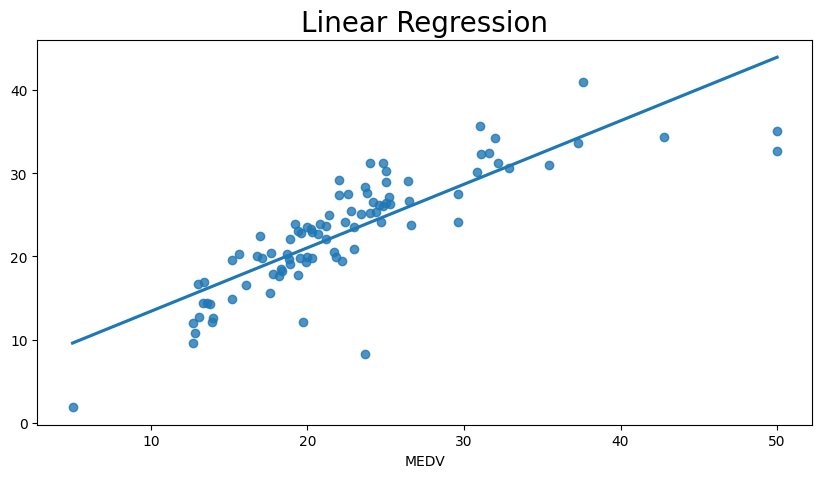

In [27]:
plt.figure(figsize=(10, 5))
sns.regplot(x = y_test, y = y_pred, ci = None)
plt.title('Linear Regression', fontsize = 20)

Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 10, random_state = 42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

ndf = [model_evaluation(random_forest, X_train, y_train, X_test, y_test, y_pred)]

random_forest_score = pd.DataFrame(data = ndf, columns = ['R2 Score', 'Adjusted R2 Score', 'Cross validated R2 score', 'RMSE'])
random_forest_score.insert(0, 'Model', 'Random Forest')
random_forest_score

,Model,R2 Score,Adjusted R2 Score,Cross validated R2 score,RMSE
0,Random Forest,0.78454,0.748163,0.800675,3.492808


XGBoost Regressor

In [34]:
from xgboost import XGBRFRegressor

xgboost = XGBRFRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state = 42)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)

ndf = [model_evaluation(random_forest, X_train, y_train, X_test, y_test, y_pred)]

xgboost_score = pd.DataFrame(data = ndf, columns = ['R2 Score', 'Adjusted R2 Score', 'Cross validated R2 score', 'RMSE'])
xgboost_score.insert(0, 'Model', 'XG Boost')
xgboost_score

,Model,R2 Score,Adjusted R2 Score,Cross validated R2 score,RMSE
0,XG Boost,0.78454,0.748163,0.800675,3.147899


In [45]:
import pickle
pickle.dump(xgboost, open('/content/drive/MyDrive/Projects/Boston Housing/xgboost.pkl', 'wb'))